# Данные

In [ ]:
# Используемые сторонние библиотеки
import numpy as np
from scipy.signal import convolve2d
import pandas as pd
import matplotlib.pyplot as plt

import os
import gc
import pickle

path_dataset = '../input/ai-masters-ds-contest-2022'
path_output = './'

df = pd.read_csv(os.path.join(path_dataset, 'train2022.csv'))
y_arr = df.iloc[:, 403:].to_numpy().reshape((-1, 20, 20)).astype('bool')

Рассмотрим функцию, используемую при формирование выборки

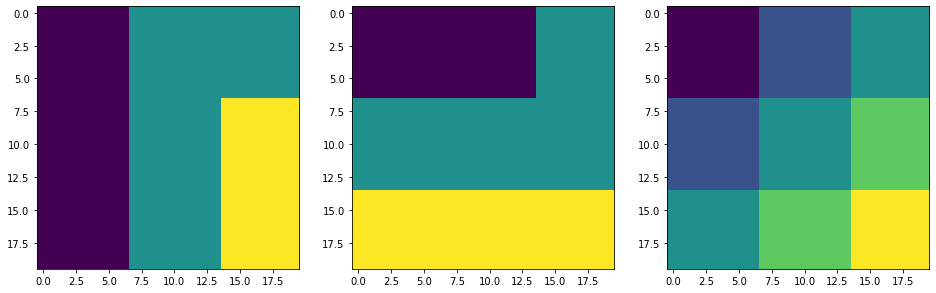

In [ ]:
n = 20
alpha = np.tile(np.floor(np.arange(n) / (n / 3)) + 1, (n, 1))
beta =  alpha.T + 1
alpha, beta = np.minimum(alpha, beta), np.maximum(alpha, beta)
gamma = (alpha + beta) / 2

def make_step(X):
    n = X.shape[0]
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='wrap') - X
    alpha = np.tile(np.floor(np.arange(n) / (n / 3)) + 1, (n, 1))
    beta =  alpha.T + 1
    alpha, beta = np.minimum(alpha, beta), np.maximum(alpha, beta)
    gamma = (alpha + beta) / 2
    return ((nbrs_count <= beta)&(nbrs_count >= gamma)) | (X & (nbrs_count >= alpha)& (nbrs_count <= gamma))

def makeksteps(X, k=3):
    for i in range(k):
        X = make_step(X)
    return (X)

fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1, 3, 1)
plt.imshow(alpha)
fig.add_subplot(1, 3, 2)
plt.imshow(beta)
fig.add_subplot(1, 3, 3)
plt.imshow(gamma)
None

Матрица, полученная применением функции make_step, принимает значение в клетки с индексом $ij$ исходя из количества соседей, её состояния и местоположения.

In [ ]:
# Вспомогательные функции
def vectorize_makeksteps(X, k=3):
    return np.vectorize(lambda y: makeksteps(y, k), signature='(n,n)->(n,n)')(X)

# Вычисляет среднее количество соседей для матриц, полученных в режиме i, через k шагов,
def mean_ngbr_ksteps(i, k):
    X = vectorize_makeksteps(y_arr[df['regime'] == i], k)
    f = lambda y: convolve2d(y, np.ones((3, 3)), mode='same', boundary='wrap') - y
    return np.mean(np.vectorize(f, signature='(n,n)->(n,n)')(X), axis=0)

def mean_ksteps(i, k):
    return np.mean(vectorize_makeksteps(y_arr[df['regime'] == i], k), axis=0)

def std_ksteps(i, k):
    return np.std(vectorize_makeksteps(y_arr[df['regime'] == i], k), axis=0)

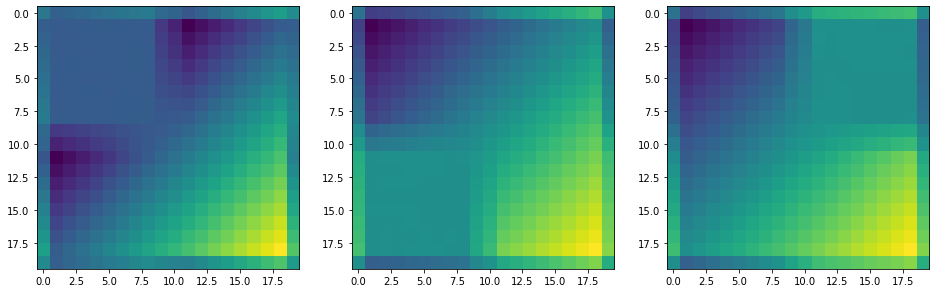

In [ ]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1, 3, 1)
plt.imshow(mean_ngbr_ksteps(0, 0))
fig.add_subplot(1, 3, 2)
plt.imshow(mean_ngbr_ksteps(1, 0))
fig.add_subplot(1, 3, 3)
plt.imshow(mean_ngbr_ksteps(2, 0))
None

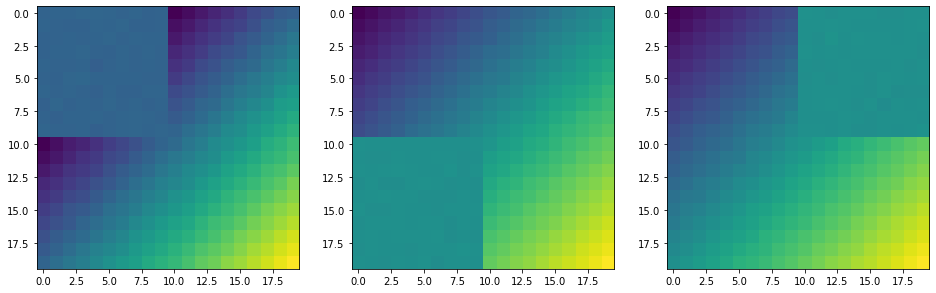

In [ ]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1, 3, 1)
plt.imshow(mean_ksteps(0, 0))
fig.add_subplot(1, 3, 2)
plt.imshow(mean_ksteps(1, 0))
fig.add_subplot(1, 3, 3)
plt.imshow(mean_ksteps(2, 0))
None

Положим  $y = (y_{ij})$ <br /> Предположение: режим влияет на расположение квадрата 10x10, элемент которого равен $1$ с вероятностью $\frac{1}{2}$, $y_{ij}$ - независимы, $P(y_{ij} = 1)$ постоянна на диагонали, т.е. $P(y_{ij} = 1)= P(y_{i - 1,j + 1} = 1)$ (за исключением квадрата 10x10, соответствующего режиму). Вычислим эту вероятность.

In [ ]:
mask0 = np.full((20, 20), 1, dtype='int')
mask1 = np.full((20, 20), 1, dtype='int')
mask2 = np.full((20, 20), 1, dtype='int')

mask0[:10, :10] = 0
mask1[10:, :10] = 0
mask2[:10, 10:] = 0

# Количество наблюдений y_ij в выборке,
# за исключением тех случаев, когда ij находится в квадрате, соответствующему режиму формирования y, y = (y_ij)
count = np.full((20, 20), df.shape[0], dtype='float')

count[:10, :10] -= df[df['regime'] == 0].shape[0]
count[10:, :10] -= df[df['regime'] == 1].shape[0]
count[:10, 10:] -= df[df['regime'] == 2].shape[0]

EX = np.concatenate((
    y_arr[df['regime'] == 0]*mask0,
    y_arr[df['regime'] == 1]*mask1,
    y_arr[df['regime'] == 2]*mask2), axis=0, dtype='float')

EX = np.sum(EX, axis=0)

# Суммируем по диагоналям и вычисляем среднее
for k in range(1, 21):
    S = 0
    n = 0
    for i in range(k):
        S += EX[(k - 1) - i, i]
        n += count[(k - 1) - i, i]

    S /= n
    for i in range(k):
        EX[(k - 1) - i, i] = S

for k in range(19, 0, -1):
    S = 0
    n = 0
    for i in range(k):
        S += EX[19 - i, (20 - k) + i]
        n += count[19 - i, (20 - k) + i]

    S /= n
    for i in range(k):
        EX[19 - i, (20 - k) + i] = S

EX0 = np.copy(EX)
EX1 = np.copy(EX)
EX2 = np.copy(EX)
EX3 = np.copy(EX)

EX0[:10, :10] = 0.5
EX1[10:, :10] = 0.5
EX2[:10, 10:] = 0.5
EX3[10:, 10:] = 0.5
EX_arr = [EX0, EX1, EX2, EX3]

Полученные матрицы будем использовать для генерации синтетических данных.

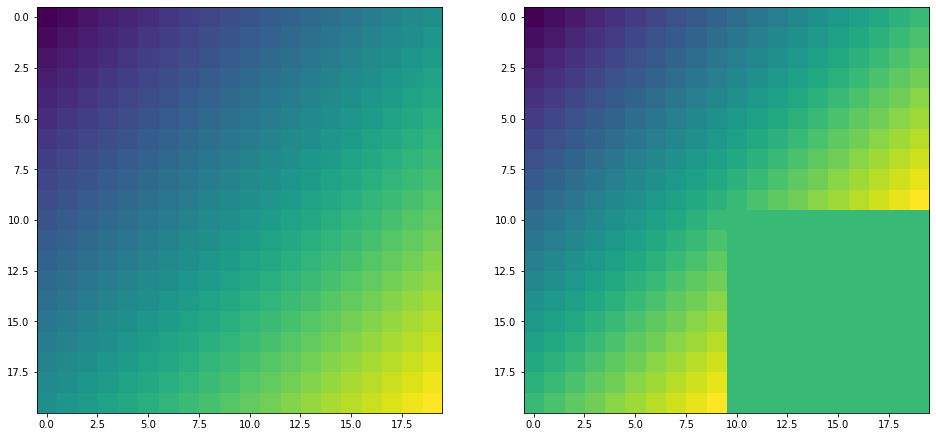

In [ ]:
def gen_data(default_rng, n, regime):
    k = min(n, 10000)
    return np.concatenate([default_rng.binomial(1, p=EX_arr[regime], size=(k, 20, 20)).astype('bool') for i in range(0, n, 10000)], axis=0)

fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1, 2, 1)
plt.imshow(EX)
fig.add_subplot(1, 2, 2)
plt.imshow(EX3)

del df
del y_arr

# Классификатор

Положим $X = (x_{ij}),\ X = \text{makeksteps}(y, k)$.
<br />
Для предсказания будем использовать наивный байессовский классификатор. $P(y_{ij} = 1)$ считаем равным EX3[i, j], $P(x_{pq} = 1 | y_{ij} = C)$ вычисляем как среднее $x_{pq}$ по подвыборки с $y_{ij} = C$.
<br />
Возможная модификация: Состояние клетки с индексом $ij$ через $k$ шагов зависит от соседей, находящихся на расстояние не более $k$, следовательно для остальных случаев $P(x_{pq} = 1 | y_{ij} = C) = P(x_{pq} = 1)$ (в предположении, что $y_{ij}$ независимы). Для $k \leq 2$ можно явно вычислить решения $x_{pq} = 1$ и затем вероятность $P(x_{pq} = 1 | y_{ij} = C)$.

In [ ]:
n = 9000000
seed = 611
rng = np.random.default_rng(seed)

# probability[steps][i, j, C, k, l]  <=> P(X_kl = 1 | y_ij = C)
probability = {steps: np.zeros((20, 20, 2, 20, 20), dtype='float') for steps in range(5)}

# Сгенерируем новые данные
X = gen_data(default_rng=rng, n=n, regime=3).astype('bool')

gc.collect()

# Индексы матриц с y_ij = 0
y_0_idx = np.moveaxis(X == 0, [0, 1, 2], [2, 0, 1])
# Индексы матриц y_ij = 1
y_1_idx = np.moveaxis(X == 1, [0, 1, 2], [2, 0, 1])

for steps in range(5):
    print(f'step={steps+1} begin')

    # Применяем функцию make_step к сгенерированным данным
    for i in range(n):
        X[i] = make_step(X[i])

    # Освобождаем память
    gc.collect()

    # Заполняем probability
    for i in range(20):
        for j in range(20):
            probability[steps][i, j, 0] = X[y_0_idx[i, j]].mean(axis=0)
            probability[steps][i, j, 1] = X[y_1_idx[i, j]].mean(axis=0)



del X
del y_0_idx
del y_1_idx

# Чекпоинт
filename = f'{n}_{seed}_clf_20x20.pickle'
with open(filename, 'wb') as f:
        pickle.dump(probability, f)

step=1 begin
step=2 begin
step=3 begin
step=4 begin
step=5 begin


In [ ]:
def predict(X):
    # X - pd.DataFrame: id, regime, steps, x_0, x_1 ... x_399

    n = X.shape[0]
    X_arr = X.iloc[:, 3:].to_numpy().reshape((n, 20, 20))
    X_inv = X_arr ^ 1 # 1 - X_arr

    prediction = np.empty((n, 20, 20), dtype='float')

    for idx in range(n):
        steps = X.iloc[idx, 2]
        for i in range(20):
            for j in range(20):

                probability_matrix_0 = probability[steps - 1][i, j, 0]
                probability_matrix_1 = probability[steps - 1][i, j, 1]
                X_matrix = X_arr[idx]
                X_inv_matrix = X_inv[idx]

                # P(X=X^0 | y_ij = 0)
                P_0 = np.prod(X_matrix*probability_matrix_0 + X_inv_matrix*(1 - probability_matrix_0))

                # P(X=X^0 | y_ij = 1)
                P_1 = np.prod(X_matrix*probability_matrix_1 + X_inv_matrix*(1 - probability_matrix_1))

                #                 P(X=X^0 | y_ij = 1)*P(y_ij = 1)
                # -----------------------------------------------------------------
                # P(X=X^0 | y_ij = 0)*P(y_ij = 0) + P(X=X^0 | y_ij = 1)*P(y_ij = 1)
                prediction[idx, i, j] = P_1/(P_0*(1 - EX3[i, j]) + P_1*EX3[i, j])

    prediction *= EX3

    return prediction

В качестве прогноза будем брать взвешенную cумму предсказания исходного классификатора и усредненного решения EX3. Попробуем подобрать веса на синтетических данных.

In [ ]:
n = 150000
seed = 327
rng = np.random.default_rng(seed)

X_gen = gen_data(default_rng=rng, n=n, regime=3).astype('bool')

filename = f'{n}_{seed}_y_20x20.pickle'
with open(filename, 'wb') as f:
        pickle.dump(X_gen, f)


for steps in range(5):

    gc.collect()

    X_gen = vectorize_makeksteps(X_gen, k=1)
    X = pd.DataFrame(data=
                     np.stack((
                         np.arange(n),
                         np.full(n, 3),
                         np.full(n, steps + 1),
                         *np.moveaxis(X_gen.reshape((-1, 400)), [0, 1], [1, 0])), axis=1),
                     columns=['id', 'regime', 'steps'] + [f'x_{i}' for i in range(400)])

    pred = predict(X)
    filename = f'{n}_{seed}_pred_20x20_step_{steps+1}.pickle'
    with open(filename, 'wb') as f:
            pickle.dump(pred, f)

del X_gen

In [ ]:
def MSE(y_true, y_pred):
    return np.mean(np.mean((y_true - y_pred)**2, axis=0))

path = os.path.join(path_output, f'{n}_{seed}_y_20x20.pickle')
with open(path, 'rb') as f:
    y = pickle.load(f).reshape((-1, 400))

EX3_broadcast = np.broadcast_to(EX3.reshape((-1, 400)), (y.shape[0], 400))

In [ ]:
steps = 1

path = os.path.join(path_output, f'{n}_{seed}_pred_20x20_step_{steps}.pickle')
with open(path, 'rb') as f:
    prediction = pickle.load(f).reshape((-1, 400))

arr = []
for a in np.arange(0.8, 0.9, 0.001):
    arr.append((a, MSE(y, a*prediction + (1 - a)*EX3_broadcast)))
arr = sorted(arr, key = lambda x: x[1])
for a, mse in arr[:5]:
    print(f'steps={steps}, a={a},', mse)

steps=1, a=0.8280000000000001, 0.19104594028324903
steps=1, a=0.8270000000000001, 0.19104598333037323
steps=1, a=0.8290000000000001, 0.19104599675983022
steps=1, a=0.8260000000000001, 0.1910461259012029
steps=1, a=0.8300000000000001, 0.19104615276011683


In [ ]:
steps = 2

path = os.path.join(path_output, f'{n}_{seed}_pred_20x20_step_{steps}.pickle')
with open(path, 'rb') as f:
    prediction = pickle.load(f).reshape((-1, 400))

arr = []
for a in np.arange(0.5, 0.64, 0.001):
    arr.append((a, MSE(y, a*prediction + (1 - a)*EX3_broadcast)))
arr = sorted(arr, key = lambda x: x[1])
for a, mse in arr[:5]:
    print(f'steps={steps}, a={a},', mse)

steps=2, a=0.5940000000000001, 0.21780449068537627
steps=2, a=0.5930000000000001, 0.21780450537101836
steps=2, a=0.5950000000000001, 0.21780451769320977
steps=2, a=0.5920000000000001, 0.2178045617501349
steps=2, a=0.5960000000000001, 0.21780458639451855


In [ ]:
steps = 3

path = os.path.join(path_output, f'{n}_{seed}_pred_20x20_step_{steps}.pickle')
with open(path, 'rb') as f:
    prediction = pickle.load(f).reshape((-1, 400))

arr = []
for a in np.arange(0.4, 0.55, 0.001):
    arr.append((a, MSE(y, a*prediction + (1 - a)*EX3_broadcast)))
arr = sorted(arr, key = lambda x: x[1])
for a, mse in arr[:5]:
    print(f'steps={steps}, a={a},', mse)

steps=3, a=0.4770000000000001, 0.2224432616437104
steps=3, a=0.4780000000000001, 0.2224432647716683
steps=3, a=0.4760000000000001, 0.2224432823268878
steps=3, a=0.4790000000000001, 0.22244329171076202
steps=3, a=0.4750000000000001, 0.2224433268212006


In [ ]:
steps = 4

path = os.path.join(path_output, f'{n}_{seed}_pred_20x20_step_{steps}.pickle')
with open(path, 'rb') as f:
    prediction = pickle.load(f).reshape((-1, 400))

arr = []
for a in np.arange(0.4, 0.5, 0.001):
    arr.append((a, MSE(y, a*prediction + (1 - a)*EX3_broadcast)))
arr = sorted(arr, key = lambda x: x[1])
for a, mse in arr[:5]:
    print(f'steps={steps}, a={a},', mse)

steps=4, a=0.44200000000000006, 0.2239219254338839
steps=4, a=0.44100000000000006, 0.22392192563341118
steps=4, a=0.44300000000000006, 0.22392193789887813
steps=4, a=0.44000000000000006, 0.22392193849745862
steps=4, a=0.44400000000000006, 0.2239219630283931


In [ ]:
steps = 5

path = os.path.join(path_output, f'{n}_{seed}_pred_20x20_step_{steps}.pickle')
with open(path, 'rb') as f:
    prediction = pickle.load(f).reshape((-1, 400))

arr = []
for a in np.arange(0.32, 0.45, 0.001):
    arr.append((a, MSE(y, a*prediction + (1 - a)*EX3_broadcast)))
arr = sorted(arr, key = lambda x: x[1])
for a, mse in arr[:5]:
    print(f'steps={steps}, a={a},', mse)

steps=5, a=0.38900000000000007, 0.22445630377560716
steps=5, a=0.39000000000000007, 0.22445630782079357
steps=5, a=0.38800000000000007, 0.22445630897938657
steps=5, a=0.39100000000000007, 0.22445632111494582
steps=5, a=0.38700000000000007, 0.22445632343213176


Получаем следующие веса

* steps=1, a=0.828, 0.19104594028324903
* steps=2, a=0.594, 0.21780449068537627
* steps=3, a=0.477, 0.2224432616437104
* steps=4, a=0.442, 0.2239219254338839
* steps=5, a=0.389, 0.22445630377560716



# Формируем ответ

In [ ]:
n = 9000000
seed = 611

df_test = pd.read_csv(os.path.join(path_dataset, 'test2022.csv'))
prediction = predict(df_test).reshape((-1, 400))

filename = f'{n}_{seed}_pred_test_20x20.pickle'
with open(filename, 'wb') as f:
        pickle.dump(prediction, f)


a = [0.828, 0.594, 0.477, 0.442, 0.389]

for steps in range(1, 6):
    idx = df_test['steps'] == steps
    df_test.loc[idx, df_test.columns[3:]] = a[steps - 1]*prediction[idx] + (1 - a[steps - 1])*EX3.reshape((-1, 400))

df_test.drop(labels=['regime', 'steps'], axis=1, inplace=True)
df_test.columns.values[1:] = [f'y_{i}' for i in range(400)]
df_test.to_csv('9kk_611_20x20_0.828_0.594_0.477_0.442_0.389.csv', index=False)